# <p><center>Predictions of Local Epidemics of Dengue Fever</p></center>

Dengue fever is a mosquito-borne illness that mainly occurs in tropical and sub-tropical environments. When a female mosquito bites and takes the blood of an infected person, that mosquito will become infected with dengue fever, and when then the mosquito will spread the infection to any others that it bites.

According to the World Health Organization, cases of Dengue fever have increased dramatically in the last few decades, and half of the world's population is currently at risk. Dengue fever can develop into the potentially lethal severe dengue, which is the leading cause of death among children in some countries.

<img src="img/location.jpg" width="600"></img>
<center><i>Figure 1.<cite><a href="http://www.nathnac.org/pro/factsheets/images/clip_image002_015.jpg"><i> Dengue fever risk map 2008.</i></a> from the World Health Organization.</cite> Dengue fever primarily occurs between 0 to 30 degrees latitiude.</i></center>

This data analysis will look at two cities in Peru, San Juan and Iquitos, and predict the total cases of dengue fever for the year and week of year for each city. The dataset includes data from NOAA's GHCN daily climate data weather station measurements, PERSIANN satellite precipitation measurements on a 0.25x0.25 degree scale, NOAA's NCEP Climate Forecast System Reanalysis measurements on a 0.5x0.5 degree scale, and satellite vegetation - NOAA's CDR Normalized Difference Vegetation Index (NDVI) on 0.5x0.5 degree scale measurements.


Significant variables we will look at in the dataset include:

<ul>
    <li>Temperature (air, dewpoint)</li>
    <li>Precipitation</li>
    <li>Humidity</li>
    <li>How "green" an area is (the NDVI)</li>
    <li>Day-Week-Month</li>
    <li>Location</li>
    
</ul>

NDVI is able to measure vegetation by using the difference between the vegetation reflecting near-infrared and the vegetation asorbing red light. NVDI ranges from -1 to +1, and negative values usually indicate water and high values usually indicate dense vegetation. Values close to zero often indicate urbanized areas. The following image shows a sattelite image of Peru's NVDI, and as we can see the areas along the coast line show less vegetation or urbanized areas.

<img src="img/NDVI.png" width="450"></img><center>Figure 3.<cite><a href="https://geonetcast.wordpress.com/2017/08/29/python-can-do-anything-3-ndvi-from-suomi-npp-in-gnc-a/"><i> NDVI satellite image of Peru from July 2017</i></a> from GEONETcast.</cite></center>

Because we are making the assumption that an increase in mosquitos is positively correlated in an increase in Dengue cases, it is helpful to understand what factors lead to a mosquito increase. This graph shows mosquito occurence compared to average rainfall, temperature, and relative humidity in Nigeria from March 2015 to February 2016. Being that the variables included in the graph are also in our dataset we can gain a better estimation on what variables will be important in our analysis.

<img src="img/weather.png" width="600"></img><center>Figure 2.<cite><a href="https://www.researchgate.net/figure/Two-most-occurring-Aedes-mosquitoes-amount-of-rainfall-temperature-and-relative_fig2_317867099"><i>Mosquito occurence in Nigeria compared with rainfall, temperature, and relative humidity</i></a> from Reasearch Gate.</cite></center>

# Data Preparation

- To start with, the cases column from the labels dataset has been joined to the training dataset. This way we can more easily compare the two.

- Null values in the datasets have been handled by replacing them with their most recent values.

- I'll create a new variable by taking the average of the NVDI scores.

In [325]:
# Import libraries
from sklearn.tree import DecisionTreeClassifier  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm 
from sklearn.metrics import explained_variance_score
from sklearn import metrics  

In [761]:
#read in csvs
f_test = pd.read_csv("data/dengue_features_test.csv")
f_train = pd.read_csv("data/dengue_features_train.csv")
labels = pd.read_csv("data/dengue_labels_train.csv")
train = f_train
train['cases'] = labels['total_cases']
train['nvdi_avg'] = train[['ndvi_ne', 'ndvi_nw','ndvi_se','ndvi_sw']].mean(axis=1)
train.fillna(method='ffill', inplace=True)

Here is an example of the dataset we are using:

In [765]:
train.sample(n=7) 

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,cases,nvdi_avg
816,sj,2006,1,2006-01-08,-0.008233,-0.045333,0.110071,0.099486,16.27,298.677143,...,16.27,15.202857,2.100000,24.657143,6.257143,28.3,20.6,8.1,10,0.038998
471,sj,1999,20,1999-05-21,0.064000,0.090667,0.194471,0.169157,33.82,299.775714,...,33.82,16.651429,3.185714,27.828571,7.328571,33.3,23.3,14.3,20,0.151432
341,sj,1996,47,1996-11-18,-0.030067,0.039525,0.060767,0.057800,42.76,298.477143,...,42.76,16.842857,1.600000,25.871429,5.600000,29.4,22.2,88.3,31,0.052697
47,sj,1991,13,1991-03-26,0.280350,0.223575,0.247883,0.247386,0.00,297.470000,...,0.00,15.148571,2.757143,26.057143,6.585714,32.2,22.2,26.9,16,0.249798
670,sj,2003,12,2003-03-19,-0.052033,0.014220,0.155643,0.182271,0.00,298.881429,...,0.00,14.884286,2.428571,26.457143,7.928571,31.1,21.7,1.3,7,0.075025
276,sj,1995,33,1995-08-20,0.083967,0.091700,0.177157,0.188671,4.05,300.554286,...,4.05,18.857143,3.342857,30.071429,6.942857,34.4,25.6,8.7,24,0.135374
1401,iq,2009,24,2009-06-11,0.187129,0.157800,0.143457,0.199471,8.74,295.104286,...,8.74,15.482857,6.242857,24.666667,8.633333,33.5,20.0,23.9,3,0.171964



# Exploratory Data Analysis

Here is the description of our dataset:

In [766]:
train.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,cases,nvdi_avg
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,2001.031593,26.503434,0.131271,0.128068,0.202606,0.201987,45.686937,298.697965,299.221483,295.245445,...,45.686937,16.745565,4.898656,27.180313,8.085646,32.443338,22.099863,39.194162,24.675137,0.169350
std,5.408314,15.019437,0.138527,0.119561,0.074409,0.083592,43.779318,1.361950,1.262676,1.527527,...,43.779318,1.542276,3.542340,1.280861,2.122836,1.960769,1.569113,47.363305,43.596000,0.090004
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000,-0.092565
25%,1997.000000,13.750000,0.039100,0.048250,0.152795,0.144455,9.655000,297.654643,298.257143,294.119643,...,9.655000,15.560000,2.328571,26.300000,6.528571,31.100000,21.100000,8.700000,5.000000,0.104068
50%,2002.000000,26.500000,0.113900,0.115926,0.195664,0.190121,38.235000,298.646429,299.285714,295.639286,...,38.235000,17.087143,2.857143,27.400000,7.364286,32.800000,22.200000,23.800000,12.000000,0.151244
75%,2005.000000,39.250000,0.232018,0.213429,0.247461,0.246775,70.227500,299.827500,300.207143,296.460000,...,70.227500,17.977500,7.617857,28.132143,9.600000,33.900000,23.300000,53.675000,28.000000,0.227523
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000,0.503982


# Dengue Fever Cases Across Time

Around the world cases of dengue fever on average have increased, but what about San Juan and Iquitos specifically? In the following graph cases of dengue fever from 1991 to 2007 for the two cities have been graphed.

In [171]:
years_cases = train.loc[train['year'] < 2008]
years_wth = train.loc[train['year'] > 1990]
years_cases = years_cases.groupby(['year']).sum()
years_cases = years_cases.reset_index()

Text(0.5, 1.0, 'Dengue Cases Over Time')

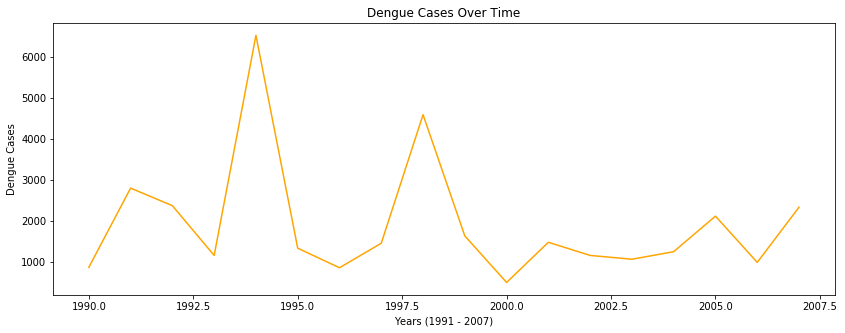

In [688]:
plt.figure(figsize=(14,5))
plt.plot(years_cases['year'], years_cases['cases'], color='orange')
plt.ylabel('Dengue Cases')
plt.xlabel('Years (1991 - 2007)')
plt.title('Dengue Cases Over Time')

San Juan and Iquitos don't quite follow the same trend of dengue cases increasing the past few decades like the rest of the world, but they are on an upward trend. I hypothesize that a possible reason the increase in dengue fever cases is global warming causing temperatures to increase. Mosquitos enjoy warm, wet environments so an increase in temperature coupled with the rainfall would be ideal conditions for their populations to grow. Let's also take a look at changes in rainfall, temperature, humidity, and an average of the NVDI's for the four directions over the years:

In [768]:
years_wth = train.loc[train['year'] < 2008]
years_wth = years_wth.loc[years_wth['year'] > 1990]
years_wth = years_wth.groupby(['year']).mean()
years_wth = years_wth.reset_index()

Text(0.5, 1.0, 'Average Temperature Over Time')

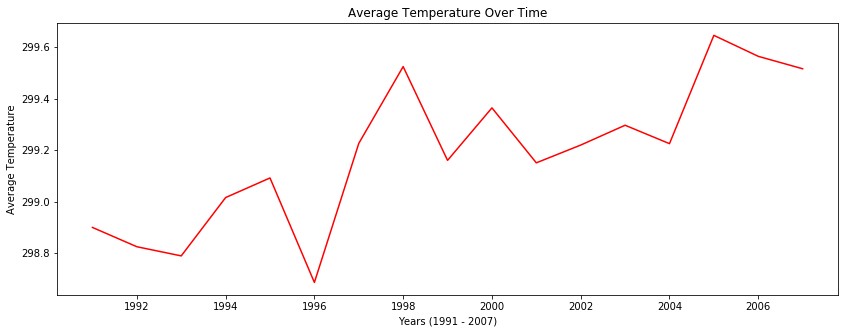

In [685]:
plt.figure(figsize=(14,5))
plt.plot(years_wth['year'], years_wth['reanalysis_avg_temp_k'], color='red')
plt.ylabel('Average Temperature')
plt.xlabel('Years (1991 - 2007)')
plt.title('Average Temperature Over Time')

Text(0.5, 1.0, 'Mean Relative Humidity Percent Over Time')

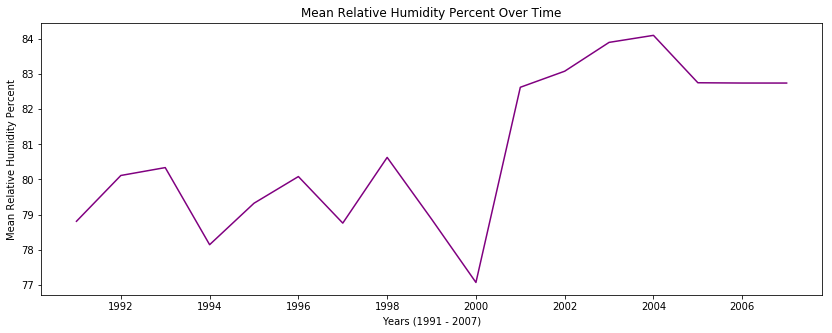

In [686]:
plt.figure(figsize=(14,5))
plt.plot(years_wth['year'], years_wth['reanalysis_relative_humidity_percent'], color='purple')
plt.ylabel('Mean Relative Humidity Percent')
plt.xlabel('Years (1991 - 2007)')
plt.title('Mean Relative Humidity Percent Over Time')

Text(0.5, 1.0, 'Total precipitation Over Time')

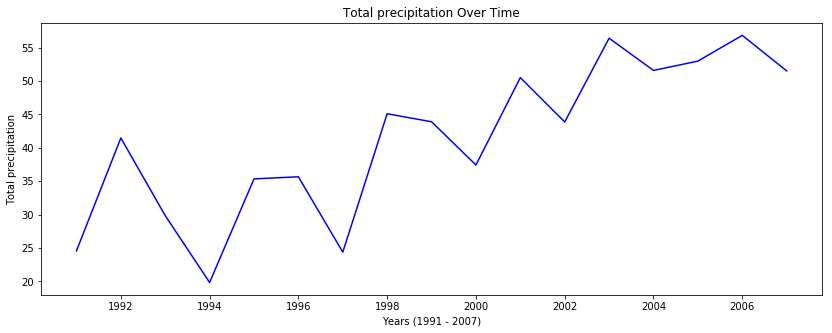

In [687]:
plt.figure(figsize=(14,5))
plt.plot(years_wth['year'], years_wth['reanalysis_sat_precip_amt_mm'], color='blue')
plt.ylabel('Total precipitation')
plt.xlabel('Years (1991 - 2007)')
plt.title('Total precipitation Over Time')

Text(0.5, 1.0, 'NVDI Average Over Time')

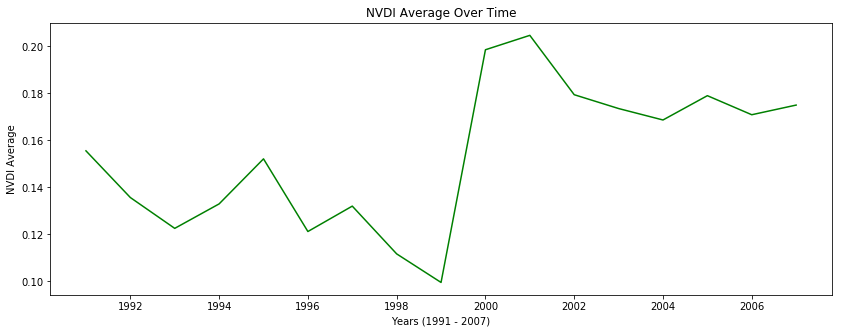

In [770]:
plt.figure(figsize=(14,5))
plt.plot(years_wth['year'], years_wth['nvdi_avg'], color='green')
plt.ylabel('NVDI Average')
plt.xlabel('Years (1991 - 2007)')
plt.title('NVDI Average Over Time')

It looks like all of these variables have been increasing as I have hypothesized. I am also interested in the fluctuations in weather conditions and the corresponding cases of dengue fever throughout a year. In the following graph I'll take the average cases for each week as well as the average rainfall, temperature, and humidity for those months.

To start with though, let's look at how cases are distributed each week:

Text(0.5, 1.0, 'Distribution of the Number of Cases Per Week')

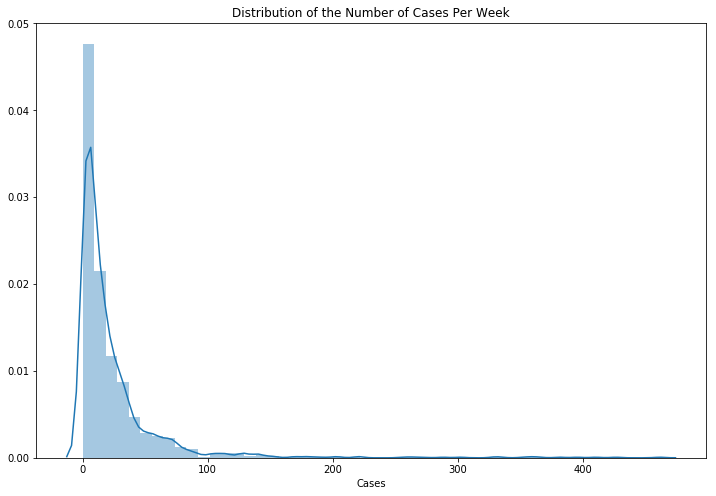

In [759]:
plt.figure(figsize=(12,8))
sns.distplot(train['cases']);
plt.xlabel('Cases')
plt.title('Distribution of the Number of Cases Per Week')

And here are visualizations of what cases, temperature, humidity, and rainfall look like throughout a year:

In [771]:
mth_wth = train.groupby(['weekofyear']).mean()
mth_wth = mth_wth.reset_index()

Text(0.5, 1.0, 'Cases Throughout a Year')

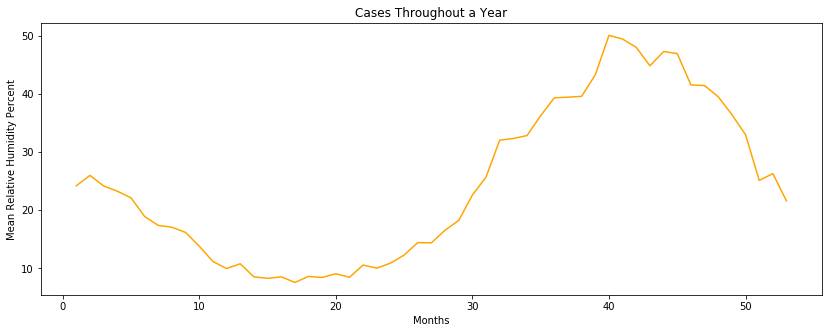

In [700]:
plt.figure(figsize=(14,5))
plt.plot(mth_wth['weekofyear'], mth_wth['cases'], color='orange')
plt.ylabel('Mean Relative Humidity Percent')
plt.xlabel('Months')
plt.title('Cases Throughout a Year')

Text(0.5, 1.0, 'Average Temperature Throughout a Year')

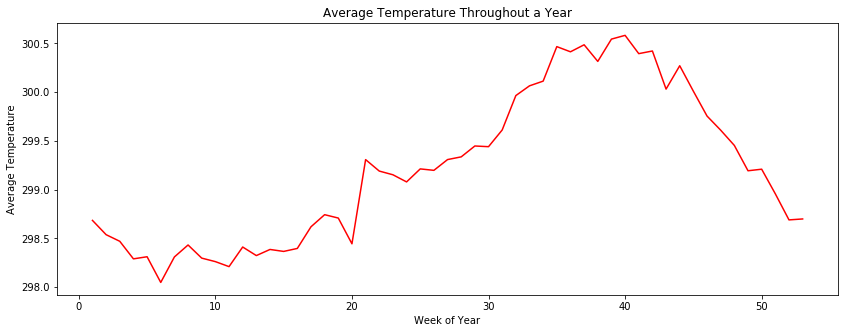

In [701]:
plt.figure(figsize=(14,5))
plt.plot(mth_wth['weekofyear'], mth_wth['reanalysis_avg_temp_k'], color='red')
plt.ylabel('Average Temperature')
plt.xlabel("Week of Year")
plt.title('Average Temperature Throughout a Year')

Average temperature has very similar fluctuations to cases week by week.

Text(0.5, 1.0, 'Mean Relative Humidity Percent Throughout a Year')

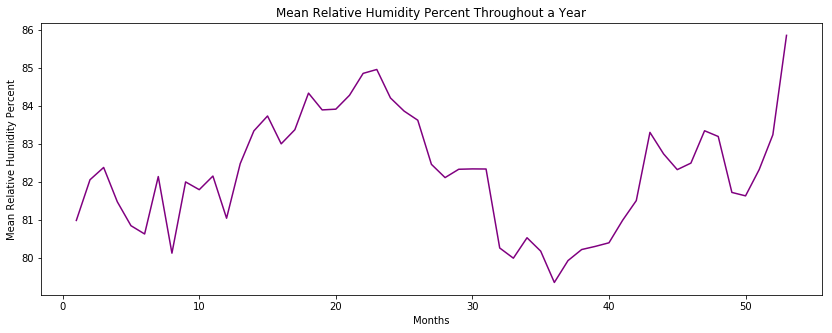

In [702]:
plt.figure(figsize=(14,5))
plt.plot(mth_wth['weekofyear'], mth_wth['reanalysis_relative_humidity_percent'], color='purple')
plt.ylabel('Mean Relative Humidity Percent')
plt.xlabel('Months')
plt.title('Mean Relative Humidity Percent Throughout a Year')

Humidity seems to increase when cases are down and decrease when they are up.

Text(0.5, 1.0, 'Total precipitation Throughout a Year')

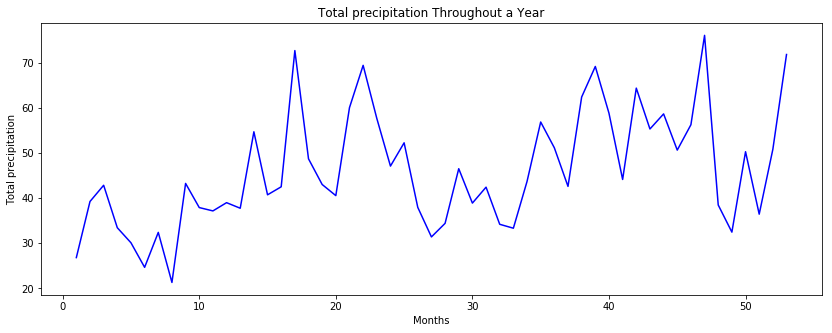

In [703]:
plt.figure(figsize=(14,5))
plt.plot(mth_wth['weekofyear'], mth_wth['reanalysis_sat_precip_amt_mm'], color='blue')
plt.ylabel('Total precipitation')
plt.xlabel('Months')
plt.title('Total precipitation Throughout a Year')

Precipitation spikes quite a bit, but overall is a similar to humidity - this makes sense as humidity is a result of higher temperatures and rainfall. The spikes are probably caused by what the temperature is.

Text(0.5, 1.0, 'NVDI Average Throughout a Year')

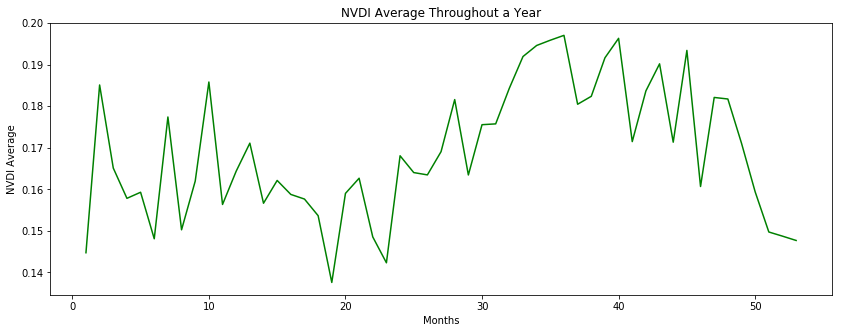

In [773]:
plt.figure(figsize=(14,5))
plt.plot(mth_wth['weekofyear'], mth_wth['nvdi_avg'], color='green')
plt.ylabel('NVDI Average')
plt.xlabel('Months')
plt.title('NVDI Average Throughout a Year')

The NVDI average fluctuations appear a bit similar to the ones from cases and percipitation.

From these graphs, the one that has the most similar fluctuations as cases is temperature and to a lesser extent the average for NVDI, where as humidity and percipitation seem to have opposite fluctuations.

# Relationships Between Variables

We want to understand what environment-related variables included in the dataset positively correlate with cases of dengue fever in San Juan and Iquitos. To do this we'll run some analysis and look at visualizations, which will allow us to determine which variables have the greatest impact. Once we do that, we will be able to use those specific variables for further data analysis.

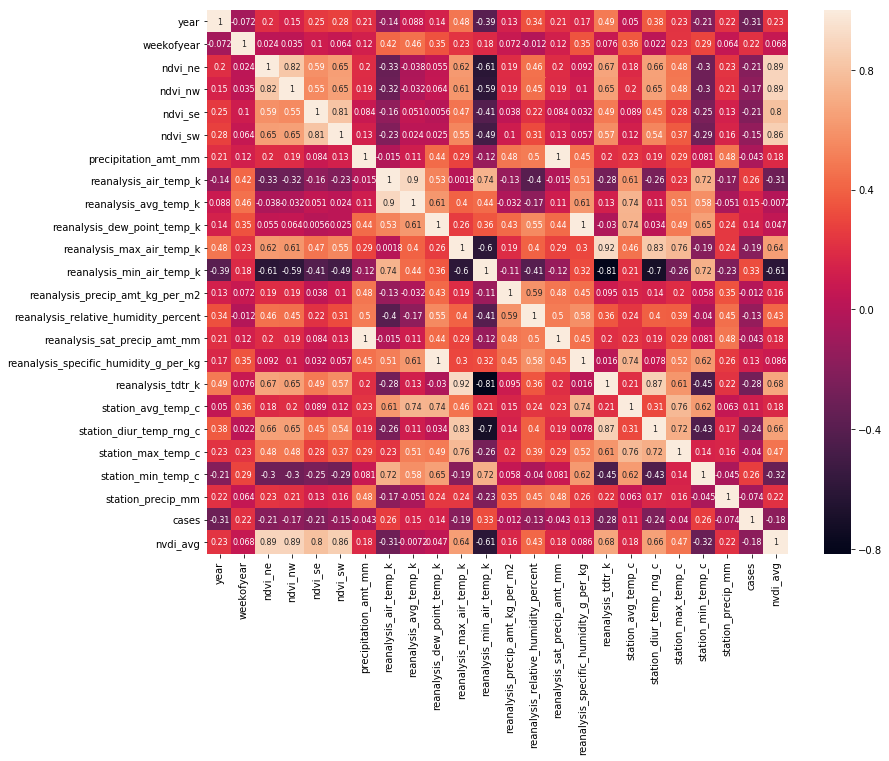

In [779]:
#Create a correlation heat map
hmap = train
hmap.fillna(method='ffill', inplace=True)
hmap['cases'] = labels['total_cases']
hmap_sj = hmap.loc[hmap['city'] == 'sj']
hmap_iq = hmap.loc[hmap['city'] == 'iq']
plt.figure(figsize=(13, 10))
sns.heatmap(hmap.drop(['city','week_start_date'],axis=1).corr(), annot=True, annot_kws={"size": 8})

We'll take a closer look at just the cases correlated with the variables in this table sorted from highest to least correlated.

In [799]:
print(train.corrwith(hmap.cases).sort_values(ascending=False))
cor_neg_pos = train.corrwith(train.cases)
corr_array = []
for i in range(23):
 corr_array.append(cor_neg_pos[i])

cases                                    1.000000
reanalysis_min_air_temp_k                0.325335
station_min_temp_c                       0.264715
reanalysis_air_temp_k                    0.263487
weekofyear                               0.216452
reanalysis_avg_temp_k                    0.149274
reanalysis_dew_point_temp_k              0.139027
reanalysis_specific_humidity_g_per_kg    0.126304
station_avg_temp_c                       0.114050
reanalysis_precip_amt_kg_per_m2         -0.011553
station_max_temp_c                      -0.040115
precipitation_amt_mm                    -0.042712
reanalysis_sat_precip_amt_mm            -0.042712
station_precip_mm                       -0.074038
reanalysis_relative_humidity_percent    -0.134824
ndvi_sw                                 -0.145284
ndvi_nw                                 -0.168386
nvdi_avg                                -0.176406
reanalysis_max_air_temp_k               -0.192775
ndvi_ne                                 -0.205105


Here we can better see that the highest correlations all have to do with temperature, with the fourth highest correlation been the week of the year. This is inline to what the line plots showed. In the following scatterplot visualizations I'll iterate through all the variables included in the dataset with cases to see all of the comparisons:

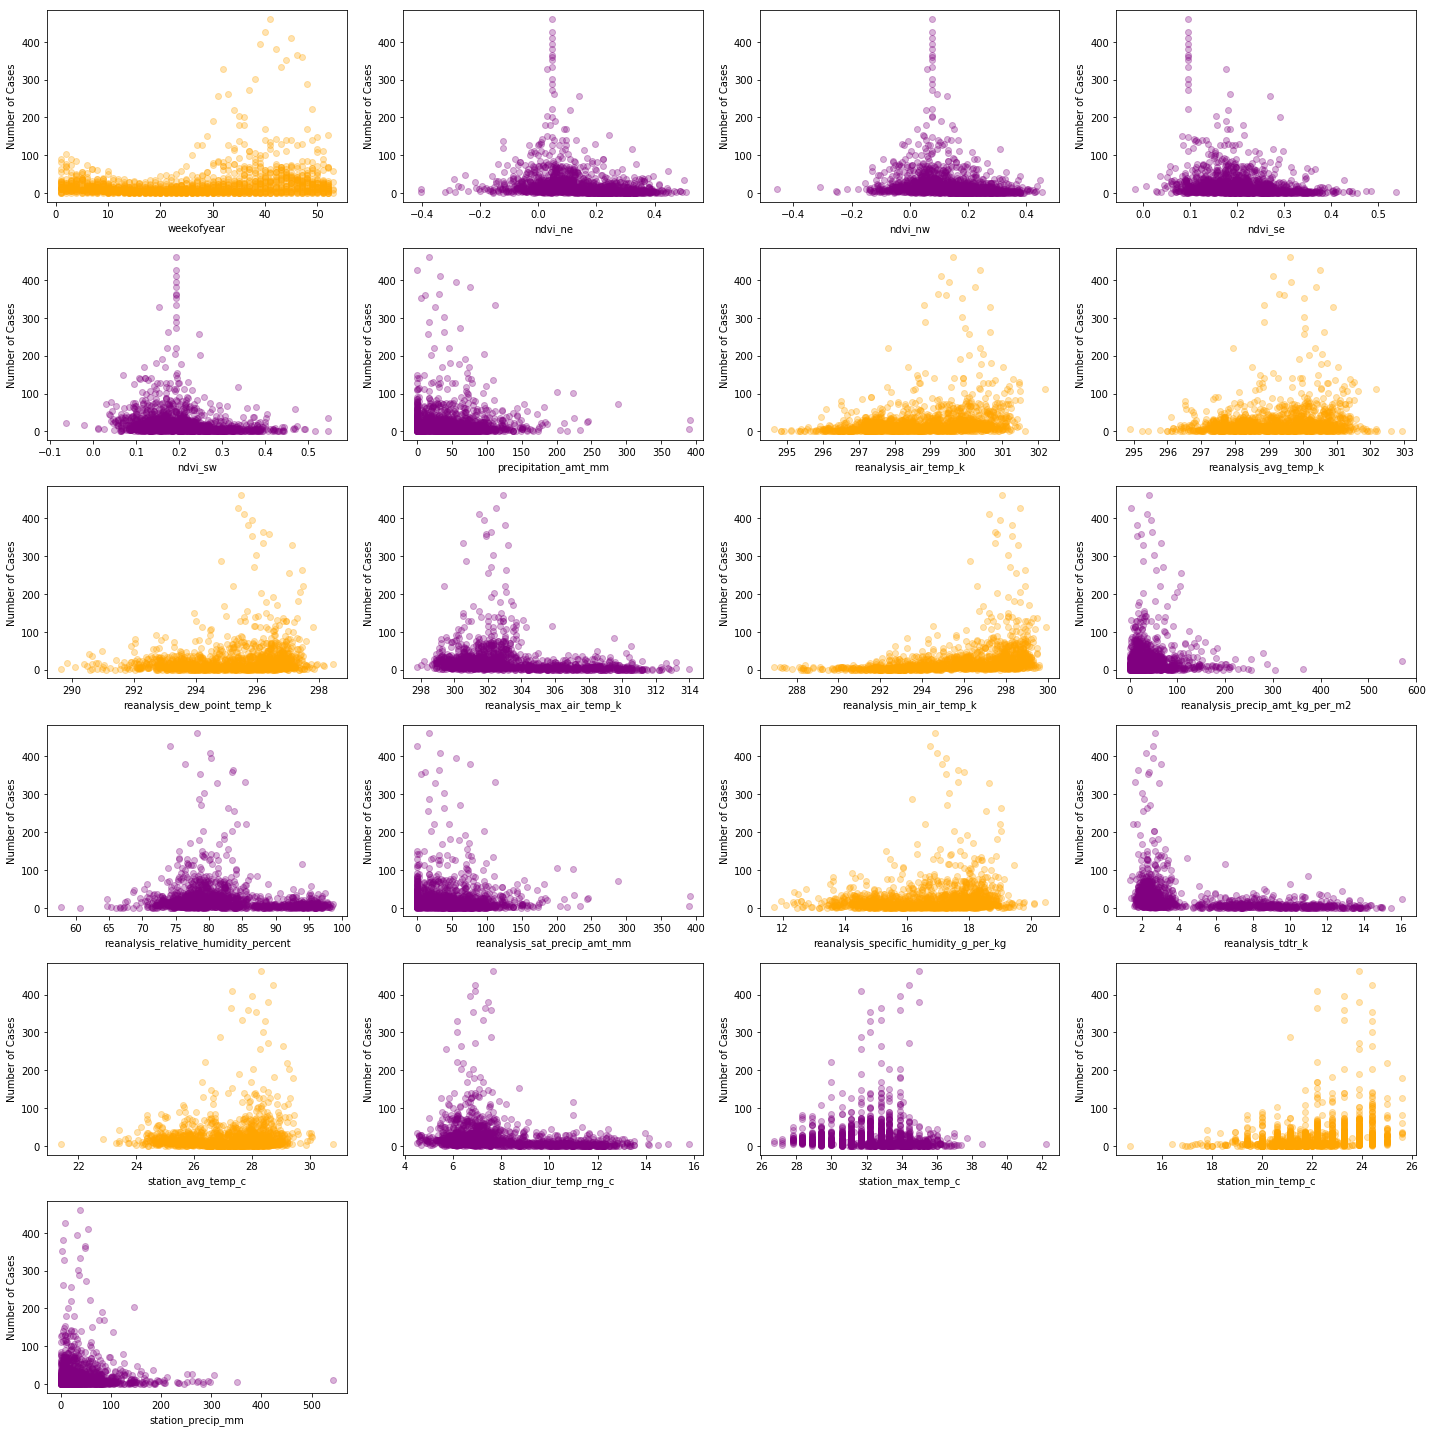

In [804]:
sp_y = train['cases']
sp = train.drop(['year', 'week_start_date'], axis = 1)
fig = plt.figure(1, figsize = [20,20])

columns = 4 
rows = 6

for i in range(1, 22):
    if corr_array[i] < 0:
        c = 'purple'
    else:
        c = 'orange'
    fig.add_subplot(rows, columns, i)
    plt.xlabel(sp.columns[i])
    plt.ylabel('Number of Cases')
    plt.scatter(sp[sp.columns[i]], sp_y, color=c, alpha=.3)

plt.tight_layout()
plt.show()




# Statistical Modeling
Because I have several quantitative explanatory variables and one dependent variable, for my statistical approach I want to use multiple linear regression. By using multiple linear regression I'll be able to see how much of a linear relationship there is between the explanatory and dependent variables, and will be able to use it to predict the values of the dependent variable using the explanatory variables.

In further analysis we'll start off by looking at the top four most correlated variables, station_min_temp_c, reanalysis_min_air_temp_k, reanalysis_air_temp_k, and weekofyear by fitting them to a multiple linear regression model. I chose these variables because their high correlations make it likely that they'll provide a good fit for the model.

## Test 1

In [817]:
#create an array to later examine differences in how explanatory variables affect the model
var_diff = []

In [836]:
#replace NaN with previous value
X = train
X['cases'] = labels['total_cases']
X.fillna(method='ffill', inplace=True)

In [837]:
X = X[['station_min_temp_c', 'reanalysis_min_air_temp_k', 'reanalysis_air_temp_k', 'weekofyear', 'cases']]


In [838]:
y = X['cases']

In [839]:
X = X.drop(['cases'], axis = 1)

In [840]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [841]:
print('R2 score: \n', r2_score(y_test, y_pred))

R2 score: 
 0.15310522150671368


We have an R squared score of about .15, meaning that the case predictions aren't very close to their actual values. 

In [842]:
print('Intercept: \n', reg.intercept_)

Intercept: 
 -1105.7166587408835


In [843]:
coeff_df = pd.DataFrame(reg.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
station_min_temp_c,0.715148
reanalysis_min_air_temp_k,5.178700
reanalysis_air_temp_k,-1.436498
weekofyear,0.467637


The intercept is -1105.7 and the coefficients are .7, 5.2, -1.4, and .5. With these we can create the equation for our linear regression model: 

In [536]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 21.498816922311445
Mean Squared Error: 2048.8811086978412
Root Mean Squared Error: 45.2645679168358


In [652]:
r2_s1 = {'test':1,'r2_score': r2_score(y_test, y_pred), 'MAE': metrics.mean_absolute_error(y_test, y_pred),
         'MSE': metrics.mean_squared_error(y_test, y_pred), 'RMSE': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
         'intercept':reg.intercept_, 'coefficients': reg.coef_, 'variables': 'station_min_temp_c, reanalysis_min_air_temp_k, reanalysis_air_temp_k, reanalysis_avg_temp_k'}
var_diff.append(r2_s1)
var_diff

[{'test': 1,
  'r2_score': 0.0868288498802231,
  'MAE': 21.498816922311445,
  'MSE': 2048.8811086978412,
  'RMSE': 45.2645679168358,
  'intercept': -1113.033884499837,
  'coefficients': array([  3.340168  ,   1.46089231,  12.13391606, -10.00129814]),
  'variables': 'station_min_temp_c, reanalysis_min_air_temp_k, reanalysis_air_temp_k, reanalysis_avg_temp_k'}]

Our mean absolute error is about 21, which is a bit large - this confirms that are model isn't performing as well as we'd like. The mean squared error is 1928, meaning that our model is likely to have some outliers contributing to this number. Our root mean square error is about 44, and we can expect for 68% of the dependent values to be within one root mean squared error, and 95% to be within two.

Becaues our results were rather dissapointing and their predictions weren't very accurate, we'll change the variables to see if we can get a better result. To do so, we'll systematically compare every possible combination of variables using forward selection to find the best model.


In [442]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [443]:
X = f_test
X['cases'] = l_train['total_cases']
X.fillna(method='ffill', inplace=True)
X = X.drop(['year','weekofyear', 'city'],axis=1)

model = forward_selected(X, 'cases')
print('Results: ' + model.model.formula)

Results: cases ~ station_min_temp_c + reanalysis_air_temp_k + ndvi_nw + station_avg_temp_c + station_max_temp_c + 1


According to forward selection, the explanatory variables to choose for the best fit of our model are station_min_temp_c, 'reanalysis_air_temp_k, ndvi_nw, station_avg_temp_c and station_max_temp_c. This is actually pretty close to the variables we chose for our first attempt. Let's use these variables to create a new linear regression model.

In [516]:
X2 = train[['station_min_temp_c', 'reanalysis_air_temp_k',  'ndvi_nw',  'station_avg_temp_c', 'station_max_temp_c', 'cases']]
y2 = X2['cases']
X2 = X2.drop(['cases'], axis = 1)

In [517]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3)
reg2 = linear_model.LinearRegression()
reg2.fit(X2_train, y2_train)
y2_pred = reg2.predict(X2_test)

In [527]:
print(r2_score(y2_test, y2_pred))
print(explained_variance_score(y2_test, y2_pred, multioutput='uniform_average'))
print('Intercept: \n', reg2.intercept_)
print('Cases = (' + str(reg2.intercept_) + ') + (' + str(reg2.coef_[0])+ ')*X1 + (' + str(round(reg2.coef_[1],2))+
      ')*X2 + (' + str(reg2.coef_[2])+ ')*X3 + (' + str(reg2.coef_[3])+ ')*X4')

0.10643194636369313
0.10680016853218088
Intercept: 
 -1943.982135795396
Cases = (-1943.982135795396) + (3.6444487255374725)*X1 + (6.67)*X2 + (-14.573177114290024)*X3 + (-3.704118090724614)*X4


In [528]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, y2_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y2_test, y2_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y2_test, y2_pred)))  

Mean Absolute Error: 21.349190503101777
Mean Squared Error: 1831.8356502466565
Root Mean Squared Error: 42.79994918509433


In [654]:
r2_s2 = {'test': 2, 'r2_score': r2_score(y2_test, y2_pred), 'MAE': metrics.mean_absolute_error(y2_test, y2_pred),
         'MSE': metrics.mean_squared_error(y2_test, y2_pred), 'RMSE': np.sqrt(metrics.mean_squared_error(y2_test, y2_pred)),
         'intercept':reg2.intercept_, 'coefficients': reg2.coef_, 'variables': 'station_min_temp_c, reanalysis_air_temp_k, ndvi_nw, station_avg_temp_c, station_max_temp_c'}
var_diff.append(r2_s2)

We're finally going to test using all of the explanatory variables

In [571]:
X3 = train
y3 = X3['cases']
X3 = X3.drop(['cases', 'weekofyear', 'week_start_date', 'city', 'year'], axis = 1)

In [572]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3)
reg3 = linear_model.LinearRegression()
reg3.fit(X3_train, y3_train)
y3_pred = reg3.predict(X3_test)

In [573]:
print(r2_score(y3_test, y3_pred))
print(explained_variance_score(y3_test, y3_pred, multioutput='uniform_average'))
print('Intercept: \n', reg3.intercept_)
print('Cases = (' + str(reg3.intercept_) + ') + (' + str(reg3.coef_[0])+ ')*X1 + (' + str(round(reg3.coef_[1],2))+
      ')*X2 + (' + str(reg3.coef_[2])+ ')*X3 + (' + str(reg3.coef_[3])+ ')*X4')

0.1435887555554184
0.15140586569239656
Intercept: 
 2229.2807167227697
Cases = (2229.2807167227697) + (5.447668600955191)*X1 + (17.11)*X2 + (-144.9861199329655)*X3 + (123.82452658154718)*X4


In [656]:
r2_s3 = {'test':3,'r2_score': r2_score(y3_test, y3_pred), 'MAE': metrics.mean_absolute_error(y3_test, y3_pred),
         'MSE': metrics.mean_squared_error(y3_test, y3_pred), 'RMSE': np.sqrt(metrics.mean_squared_error(y3_test, y3_pred)),
         'intercept':reg3.intercept_, 'coefficients': reg3.coef_, 'variables':'station_min_temp_c, reanalysis_air_temp_k, ndvi_nw, station_avg_temp_c and station_max_temp_c'}
var_diff.append(r2_s3)

Lastly I want to see if variables related to date will give my model a better fit.

In [600]:
X4 = train
y4 = X4['cases']
X4 = X4.drop(['cases', 'week_start_date', 'city'], axis = 1)

In [601]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3)
reg4 = linear_model.LinearRegression()
reg4.fit(X4_train, y4_train)
y4_pred = reg4.predict(X4_test)

In [602]:
print(r2_score(y4_test, y4_pred))
print(explained_variance_score(y4_test, y4_pred, multioutput='uniform_average'))
print('Intercept: \n', reg4.intercept_)
print('Cases = (' + str(reg4.intercept_) + ') + (' + str(reg3.coef_[0])+ ')*X1 + (' + str(round(reg3.coef_[1],2))+
      ')*X2 + (' + str(reg3.coef_[2])+ ')*X3 + (' + str(reg3.coef_[3])+ ')*X4')

0.21873113819486378
0.2209557832443837
Intercept: 
 9514.463517973283
Cases = (9514.463517973283) + (5.447668600955191)*X1 + (17.11)*X2 + (-144.9861199329655)*X3 + (123.82452658154718)*X4


In [658]:
r2_s4 = {'test':4,'r2_score': r2_score(y4_test, y4_pred), 'MAE': metrics.mean_absolute_error(y4_test, y4_pred),
         'MSE': metrics.mean_squared_error(y4_test, y4_pred), 'RMSE': np.sqrt(metrics.mean_squared_error(y4_test, y4_pred)),
         'intercept':reg4.intercept_, 'coefficients': reg4.coef_, 'variables':'year, weekofyear, station_min_temp_c, reanalysis_air_temp_k, ndvi_nw, station_avg_temp_c and station_max_temp_c'}
var_diff.append(r2_s4)

In [660]:
var_diff_df=pd.DataFrame(var_diff)
var_diff_df

,MAE,MSE,RMSE,coefficients,intercept,r2_score,test,variables
0,21.498817,2048.881109,45.264568,"[3.340168000347966, 1.4608923082833492, 12.133...",-1113.033884,0.086829,1,"station_min_temp_c, reanalysis_min_air_temp_k,..."
1,21.349191,1831.835650,42.799949,"[3.6444487255374725, 6.6673513155140665, -14.5...",-1943.982136,0.106432,2,"station_min_temp_c, reanalysis_air_temp_k, ndv..."
2,22.332116,1981.400139,44.512921,"[5.447668600955191, 17.109360501578692, -144.9...",2229.280717,0.143589,3,"station_min_temp_c, reanalysis_air_temp_k, ndv..."
3,20.562461,1376.605373,37.102633,"[-1.7987982924149697, 0.40711774569665987, -15...",9514.463518,0.218731,4,"year, weekofyear, station_min_temp_c, reanalys..."


In [634]:
num = list(range(437))

Text(0.5, 1.0, "['Accuracy of model predictions when covariates used are station_min_temp_c, reanalysis_min_air_temp_k, reanalysis_air_temp_k, reanalysis_avg_temp_k']")

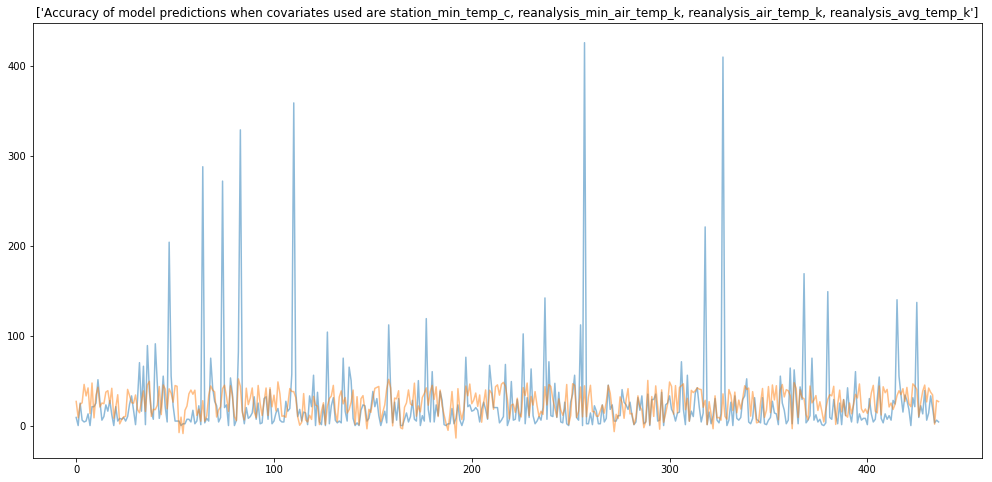

In [674]:
plt.figure(figsize=(17,8))
plt.plot(num, y_test, alpha = .5)
plt.plot(num, y_pred, alpha = .5)
plt.title('Accuracy of model predictions when covariates used are ' + var_diff_df.loc[var_diff_df['test'] == 1].variables.values)


Text(0.5, 1.0, "['Accuracy of model predictions when covariates used are station_min_temp_c, reanalysis_air_temp_k, ndvi_nw, station_avg_temp_c, station_max_temp_c']")

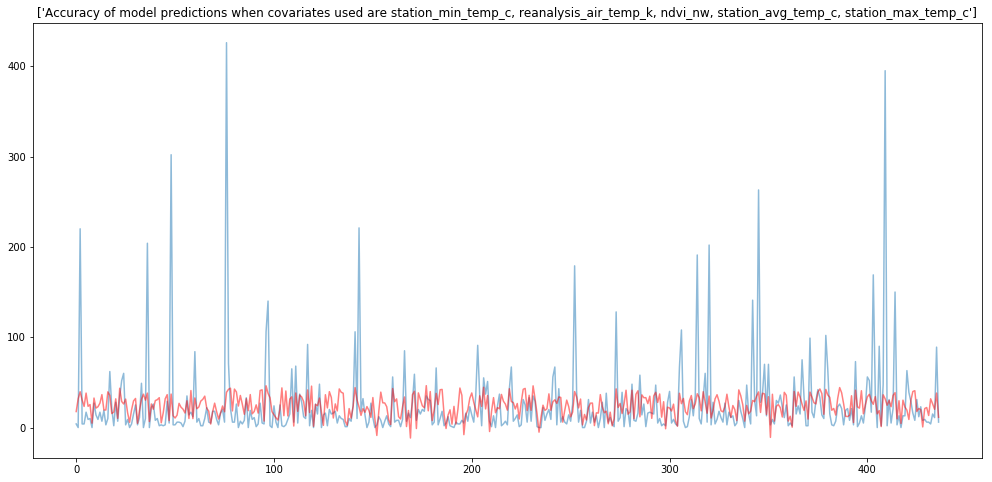

In [675]:
plt.figure(figsize=(17,8))
plt.plot(num, y2_test, alpha = .5)
plt.plot(num, y2_pred, alpha = .5, color='red')
plt.title('Accuracy of model predictions when covariates used are ' + var_diff_df.loc[var_diff_df['test'] == 2].variables.values)


Text(0.5, 1.0, "['Accuracy of model predictions when covariates used are station_min_temp_c, reanalysis_air_temp_k, ndvi_nw, station_avg_temp_c and station_max_temp_c']")

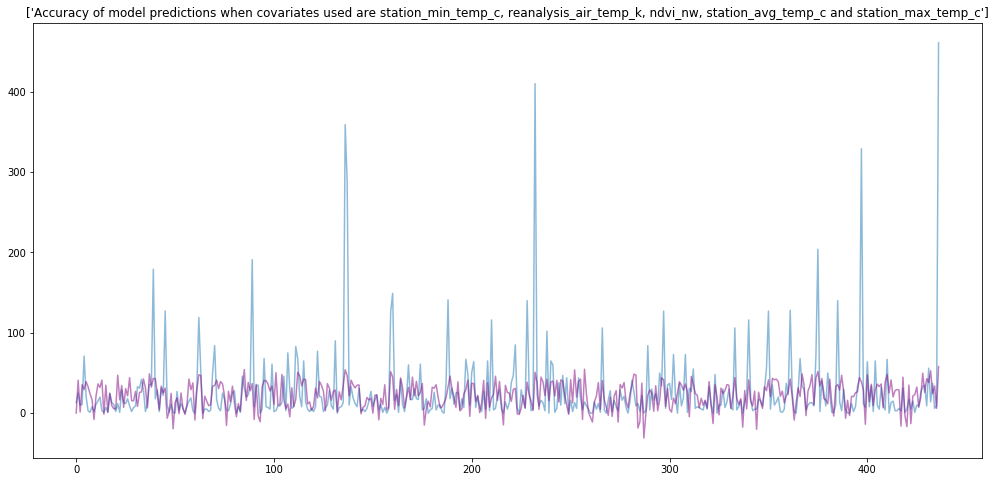

In [676]:
plt.figure(figsize=(17,8))
plt.plot(num, y3_test, alpha = .5)
plt.plot(num, y3_pred, alpha = .5, color='purple')
plt.title('Accuracy of model predictions when covariates used are ' + var_diff_df.loc[var_diff_df['test'] == 3].variables.values)


Text(0.5, 1.0, "['Accuracy of model predictions when covariates used are year, weekofyear, station_min_temp_c, reanalysis_air_temp_k, ndvi_nw, station_avg_temp_c and station_max_temp_c']")

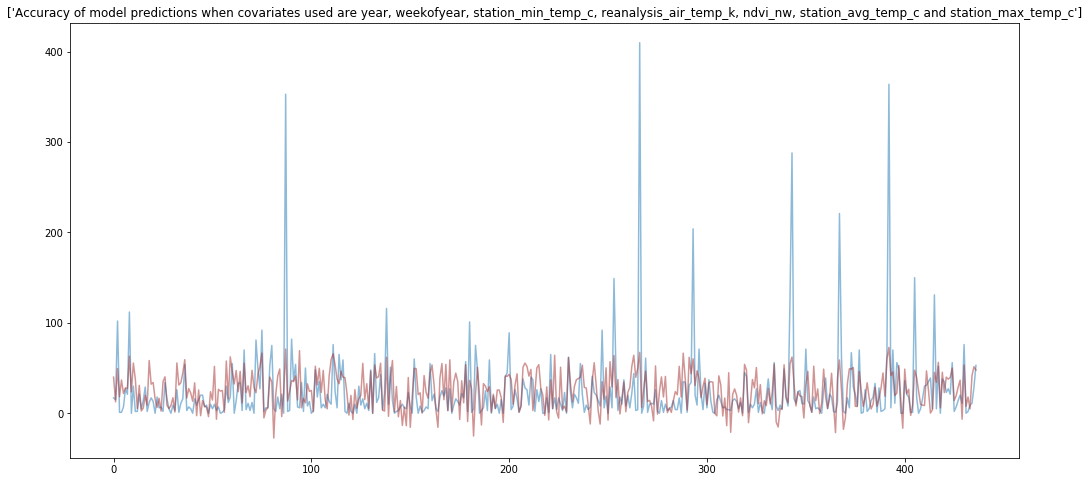

In [677]:
plt.figure(figsize=(17,8))
plt.plot(num, y4_test, alpha = .5)
plt.plot(num, y4_pred, alpha = .5, color='brown')
plt.title('Accuracy of model predictions when covariates used are ' + var_diff_df.loc[var_diff_df['test'] == 4].variables.values)



# Interpretation 
In this section, you should present and evaluate the results of your (best) statistical model. Using both written and visual approaches, you should express how well your models fit your data. Be sure to:

Report on the goodness of fit of your model
Interpret the significance and meaning of each variable you included
In this section, you should convey a nuanced understanding of the strength of relationships discovered in your models, as well as the overall accuracy of the models themselves. 